In [1]:
import os
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'

import psutil

# Get the current process
p = psutil.Process(os.getpid())

# Set the process to run only on the first CPU core
p.cpu_affinity([5])

In [2]:
import os
import gc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import anndata as ad
import numpy as np
import yaml
import sys
import h5py
import logging
import scanpy as sc
from os.path import join
import scipy.sparse as sps
from sklearn.cluster import KMeans
import gzip
from scipy.io import mmread
from pathlib import Path, PurePath

import scglue

import warnings
def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

from sklearn.metrics import adjusted_rand_score

def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v

def eval_ads(ads, ref_key, src_key, exclude=[]):
    aris = []
    for ad in ads:
        _mask = ~ad.obs[ref_key].isin(exclude)
        gt = ad.obs[ref_key].values[_mask]
        pred = ad.obs[src_key].values[_mask]
        aris.append(adjusted_rand_score(pred, gt))
    return aris

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
def search_louvain(ad, use_rep, n_neighbors=15, n_clusters=5):
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep=use_rep)
    rs = np.arange(0.1, 1.0, 0.1)
    n_cs = []
    for r in rs:
        sc.tl.louvain(ad, resolution=r, key_added=f'r={r}')
        n_cs.append(ad.obs[f'r={r}'].nunique())
    n_cs = np.array(n_cs)
    if (n_cs==n_clusters).sum() >= 1:
        ri = np.where(n_cs==n_clusters)[0][0]
        ad.obs['louvain_k'] = ad.obs[f'r={rs[ri]}'].to_list()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ad.obsm[use_rep])
        ad.obs['louvain_k'] = kmeans.labels_.astype('str')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_data(_dir):
    feat_names = pd.read_csv(join(_dir, 'features.tsv.gz'), compression='gzip', sep='\t', header=None)
    barcodes   = pd.read_csv(join(_dir, 'barcodes.tsv.gz'), compression='gzip', sep='\t', header=None)

    with gzip.open(join(_dir, 'matrix.mtx.gz'), 'rb') as gzipped_file:
        mat = mmread(gzipped_file)

    ad = sc.AnnData(sps.csr_matrix(mat.T))
    ad.obs_names = barcodes[0].values
    ad.var_names = feat_names[1].values
    ad.var['id'] = feat_names[0].values
    ad.var['type'] = feat_names[2].values
    return ad

import json
import copy
from matplotlib.image import imread
def load_spatial(path, adata, library_id='0'):
    tissue_positions_file = join(path, "tissue_positions.csv")
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=join(path, "scalefactors_json.json"),
        hires_image=join(path, "tissue_hires_image.png"),
        lowres_image=join(path, "tissue_lowres_image.png"),
    )
    
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()
    adata.uns["spatial"][library_id]["images"] = dict()
    for res in ["hires", "lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_bytes()
    )

    # adata.uns["spatial"][library_id]["metadata"] = {
    #     k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #     for k in ("chemistry_description", "software_version")
    #     if k in attrs
    # }

    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header=0 if Path(tissue_positions_file).name == "tissue_positions.csv" else None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    # print(positions.head())

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm["spatial"] = adata.obs[
        ["pxl_row_in_fullres", "pxl_col_in_fullres"]
    ].to_numpy()
   
    adata.obs.drop(
        columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
        inplace=True,
    )

In [3]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

import copy
def std_prep(ad, n_hvg=5000, hvg_flav='v3', scale=False):
    ad.X = copy.deepcopy(ad.layers['counts'])
    
    if n_hvg and hvg_flav=='v3':
        sc.pp.highly_variable_genes(ad, n_top_genes=n_hvg, flavor='seurat_v3')
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    if n_hvg and hvg_flav=='v2':
        sc.pp.highly_variable_genes(ad, n_top_genes=n_hvg)
    if scale:
        sc.pp.scale(ad)
    sc.pp.pca(ad, n_comps=min(50, ad.n_vars-1))

### Training and running

In [4]:
sys.path.insert(0, './resources')
import utils
import scipy.io as sio

In [5]:
out_dir = './cache/Tonsil/rep1-rep2-rep3'
os.makedirs(out_dir, exist_ok=True)
## best setting for simulation experiments
n_genes = 5000
latent_dim = 20
x2u_h_depth = 2
x2u_h_dim = 512
u2x_h_depth = 1
u2x_h_dim = 128
du_h_depth = 2
du_h_dim = 128
dropout = 0.2
lam_data = 1.0
lam_kl = 1.0
lam_align = 2.0
lam_cross = 2.0
lam_cos = 1.0
normalize_u = True
random_seed = 5

## multiome setting
# n_genes = 10000
# latent_dim = 50
# x2u_h_depth = 2
# x2u_h_dim = 512
# u2x_h_depth = 1
# u2x_h_dim = 256
# du_h_depth = 1
# du_h_dim = 256
# dropout = 0.2
# lam_data = 1.0
# lam_kl = 0.3
# lam_align = 0.02
# lam_cross = 1.0
# lam_cos = 0.02
# normalize_u = True
# random_seed = 2

max_epochs1 = 200
max_epochs2 = 50

In [6]:
data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_node/TN-2024-new/outs'

ad3 = load_data(join(data_dir, 'filtered_feature_bc_matrix'))
ad3_rna = ad3[:, ad3.var['type']=='Gene Expression'].copy()
ad3_adt = ad3[:, ad3.var['type']=='Antibody Capture'].copy()
load_spatial(join(data_dir, 'spatial'), ad3_rna)
load_spatial(join(data_dir, 'spatial'), ad3_adt)

ad3_rna.obs['src'] = ad3_adt.obs['src'] = ['s3']*ad3_rna.n_obs
ad3_rna.obs_names = [f's3-{x}' for x in ad3_rna.obs_names]
ad3_adt.obs_names = [f's3-{x}' for x in ad3_adt.obs_names]

ad3_rna.var_names_make_unique()
ad3_adt.var_names_make_unique()

data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_tonsil_ramen'

ad_a1_rna = sc.read_h5ad(join(data_dir, 'tonsil_A1/adata_RNA.h5ad'))
ad_a1_adt = sc.read_h5ad(join(data_dir, 'tonsil_A1/adata_ADT.h5ad'))
ad_a1_rna.var_names_make_unique()
ad_a1_adt.var_names_make_unique()
meta1 = pd.read_csv(join(data_dir, 'tonsil_A1/A1_TNSL_Kwoh.csv'), index_col=0) 
ad_a1_rna.obs['lab'] = meta1.loc[ad_a1_rna.obs_names, 'manual'].to_list()
ad_a1_adt.obs['lab'] = meta1.loc[ad_a1_adt.obs_names, 'manual'].to_list()
ad_a1_rna.obs['src'] = ad_a1_adt.obs['src'] = ['s1'] * ad_a1_rna.n_obs
ad_a1_rna.obs_names = [f's1-{x}' for x in ad_a1_rna.obs_names]
ad_a1_adt.obs_names = [f's1-{x}' for x in ad_a1_adt.obs_names]

ad_d1_rna = sc.read_h5ad(join(data_dir, 'tonsil_D1/adata_RNA.h5ad'))
ad_d1_adt = sc.read_h5ad(join(data_dir, 'tonsil_D1/adata_ADT.h5ad'))
ad_d1_rna.var_names_make_unique()
ad_d1_adt.var_names_make_unique()
meta2 = pd.read_csv(join(data_dir, 'tonsil_D1/D1_TNSL_cloupe_Kwoh.csv'), index_col=0) 
ad_d1_rna.obs['lab'] = meta2.loc[ad_d1_rna.obs_names, 'manual'].to_list()
ad_d1_adt.obs['lab'] = meta2.loc[ad_d1_adt.obs_names, 'manual'].to_list()
ad_d1_rna.obs['src'] = ad_d1_adt.obs['src'] = ['s2'] * ad_d1_rna.n_obs
ad_d1_rna.obs_names = [f's2-{x}' for x in ad_d1_rna.obs_names]
ad_d1_adt.obs_names = [f's2-{x}' for x in ad_d1_adt.obs_names]

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/

In [7]:
ad_rna_all = sc.concat([ad_a1_rna, ad_d1_rna, ad3_rna])
ad_adt_all = sc.concat([ad_a1_adt, ad_d1_adt, ad3_adt])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()
hvp_names = ad_adt_all.var_names.to_list()

In [8]:
input_train_mod1 = ad_a1_rna[:, hvg_names].copy()
input_train_mod2 = ad_a1_adt[:, hvp_names].copy()
input_test_mod1 = ad_d1_rna[:, hvg_names].copy()
input_test_mod2 = ad3_adt[:, hvp_names].copy()

input_train_mod1.X = sps.csr_matrix(input_train_mod1.X)
input_train_mod2.X = sps.csr_matrix(input_train_mod2.X)
input_train_mod1.layers['counts'] = sps.csr_matrix(input_train_mod1.X)
input_train_mod2.layers['counts'] = sps.csr_matrix(input_train_mod2.X)
input_test_mod1.X = sps.csr_matrix(input_test_mod1.X)
input_test_mod2.X = sps.csr_matrix(input_test_mod2.X)
input_test_mod1.layers['counts'] = sps.csr_matrix(input_test_mod1.X)
input_test_mod2.layers['counts'] = sps.csr_matrix(input_test_mod2.X)

input_train_mod1.obs["uid"] = [f"train-{i}" for i in range(input_train_mod1.shape[0])]
input_train_mod2.obs["uid"] = [f"train-{i}" for i in range(input_train_mod2.shape[0])]
input_test_mod1.obs["uid"] = [f"test-mod1-{i}" for i in range(input_test_mod1.shape[0])]
input_test_mod2.obs["uid"] = [f"test-mod2-{i}" for i in range(input_test_mod2.shape[0])]

input_train_mod1.obs['batch'] = input_train_mod1.obs['src'].to_list()
input_train_mod2.obs['batch'] = input_train_mod2.obs['src'].to_list()
input_test_mod1.obs['batch'] = input_test_mod1.obs['src'].to_list()
input_test_mod2.obs['batch'] = input_test_mod2.obs['src'].to_list()

print('Reading `h5ad` files...')
omics = "cite"

gex = input_train_mod1
other = input_train_mod2

print('Preprocessing GEX...')
gex_prep = utils.GEXPreprocessing(n_comps=100, n_genes=n_genes, merge_adt=omics == "cite")
gex_prep.fit_transform(gex)
print('Preprocessing ADT...')
other_prep = utils.ADTPreprocessing(n_comps=100)
other_prep.fit_transform(other)

with open(os.path.join(out_dir, "prep.pickle"), "wb") as f:
    pickle.dump({
        "gex_prep": gex_prep,
        "other_prep": other_prep
    }, f)

with open(f"{out_dir}/hyperparams.yaml", "w") as f:
    yaml.dump({
        "n_genes": n_genes,
        "latent_dim": latent_dim,
        "x2u_h_depth": x2u_h_depth,
        "x2u_h_dim": x2u_h_dim,
        "u2x_h_depth": u2x_h_depth,
        "u2x_h_dim": u2x_h_dim,
        "du_h_depth": du_h_depth,
        "du_h_dim": du_h_dim,
        "dropout": dropout,
        "lam_data": lam_data,
        "lam_kl": lam_kl,
        "lam_align": lam_align,
        "lam_cross": lam_cross,
        "lam_cos": lam_cos,
        "normalize_u": normalize_u,
        "random_seed": random_seed
    }, f)

scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)

print('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=latent_dim,
    x2u_h_depth=x2u_h_depth,
    x2u_h_dim=x2u_h_dim,
    u2x_h_depth=u2x_h_depth,
    u2x_h_dim=u2x_h_dim,
    du_h_depth=du_h_depth,
    du_h_dim=du_h_dim,
    dropout=dropout,
    shared_batches=False,
    random_seed=random_seed
)

print('Compiling model...')
model.compile(
    lam_data=lam_data, lam_kl=lam_kl, lam_align=lam_align,
    lam_cross=lam_cross, lam_cos=lam_cos, normalize_u=normalize_u,
    domain_weight={"gex": 1, "other": 1}
)

# help(model.fit)
print('Training model...')
model.fit(
    {"gex": gex, "other": other}, max_epochs=max_epochs1,
)
model.save(os.path.join(out_dir, "pretrain.dill"))

# ===============================
#               stage 2
# ===============================

logging.info('Concatenating training and test data...')
input_mod1 = ad.concat(
    {"train": input_train_mod1, "test": input_test_mod1},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod1.uns["feature_type"] = 'GEX'

input_mod2 = ad.concat(
    {"train": input_train_mod2, "test": input_test_mod2},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod2.uns["feature_type"] = 'ADT'

gex, other = input_mod1, input_mod2

logging.info('Reading preprocessors...')
with open(os.path.join(
       out_dir, "prep.pickle"
), "rb") as f:
    prep = pickle.load(f)
    gex_prep = prep["gex_prep"]
    other_prep = prep["other_prep"]

logging.info('Preprocessing...')
gex_prep.transform(gex)
other_prep.transform(other)

logging.info('Fine-tuning model...')
scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)

with open(os.path.join(
        out_dir, "hyperparams.yaml"
), "r") as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)

logging.info('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=hyperparams["latent_dim"],
    x2u_h_depth=hyperparams["x2u_h_depth"],
    x2u_h_dim=hyperparams["x2u_h_dim"],
    u2x_h_depth=hyperparams["u2x_h_depth"],
    u2x_h_dim=hyperparams["u2x_h_dim"],
    du_h_depth=hyperparams["du_h_depth"],
    du_h_dim=hyperparams["du_h_dim"],
    dropout=hyperparams["dropout"],
    shared_batches=False,
    random_seed=hyperparams["random_seed"]
)
# print(model.net)

logging.info('Adopting pretrained weights...')
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    out_dir, "pretrain.dill"
)))

logging.info('Compiling model...')
model.compile(
    lam_data=hyperparams["lam_data"],
    lam_kl=hyperparams["lam_kl"],
    lam_align=hyperparams["lam_align"],
    lam_cross=hyperparams["lam_cross"],
    lam_cos=hyperparams["lam_cos"],
    normalize_u=hyperparams["normalize_u"],
    domain_weight={"gex": 1, "other": 1},
    lr=1e-3  # TODO: Fine-tuning learning rate
)

logging.info('Training model...')
model.fit(
    {"gex": gex, "other": other},
    align_burnin=0, max_epochs=max_epochs2,
    patience=8, reduce_lr_patience=3
)

logging.info('Projecting cell embeddings...')
gex.obsm["X_model"] = model.encode_data("gex", gex)
other.obsm["X_model"] = model.encode_data("other", other)

input_train_mod1.obsm['emb'] = gex.obsm["X_model"][:input_train_mod1.n_obs]
input_test_mod1.obsm['emb'] = gex.obsm["X_model"][input_train_mod1.n_obs:]

input_train_mod2.obsm['emb'] = other.obsm["X_model"][:input_train_mod2.n_obs]
input_test_mod2.obsm['emb'] = other.obsm["X_model"][input_train_mod2.n_obs:]

ad_train_mean_enc = sc.AnnData(
    (input_train_mod1.obsm['emb'] + input_train_mod2.obsm['emb'])/2, 
    obs=input_train_mod1.obs.copy()
)
ad_train_mean_enc.obsm['emb'] = ad_train_mean_enc.X.copy()
ad_train_mean_enc.obsm['spatial'] = input_train_mod1.obsm['spatial']
ad_mosaic = sc.concat([ad_train_mean_enc, input_test_mod1, input_test_mod2])

Reading `h5ad` files...
Preprocessing GEX...
Preprocessing ADT...
Building model...
[INFO] autodevice: Using GPU 2 as computation device.
Compiling model...
Training model...
[INFO] SCCLUEModel: Setting `align_burnin` = 197
[INFO] SCCLUEModel: Setting `patience` = 148
[INFO] SCCLUEModel: Setting `reduce_lr_patience` = 50
[INFO] SCCLUETrainer: Using training directory: "/tmp/GLUETMPjrbhyfwx"
[INFO] SCCLUETrainer: [Epoch 10] train={'dsc_loss': 0.676, 'gen_loss': 79.876, 'cross_loss': 26.719, 'cos_loss': 0.38, 'x_gex_nll': 0.349, 'x_gex_kl': 0.008, 'x_gex_elbo': 0.357, 'x_other_nll': 26.394, 'x_other_kl': 0.66, 'x_other_elbo': 27.054}, val={'dsc_loss': 0.676, 'gen_loss': 82.306, 'cross_loss': 27.615, 'cos_loss': 0.346, 'x_gex_nll': 0.341, 'x_gex_kl': 0.007, 'x_gex_elbo': 0.348, 'x_other_nll': 27.244, 'x_other_kl': 0.49, 'x_other_elbo': 27.735}, 1.1s elapsed
[INFO] SCCLUETrainer: [Epoch 20] train={'dsc_loss': 0.686, 'gen_loss': 59.455, 'cross_loss': 19.996, 'cos_loss': 0.334, 'x_gex_nll': 

INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


[INFO] SCCLUETrainer: Using training directory: "/tmp/GLUETMPvjevg8su"


INFO:SCCLUETrainer:Using training directory: "/tmp/GLUETMPvjevg8su"


[INFO] SCCLUETrainer: [Epoch 10] train={'dsc_loss': 0.69, 'gen_loss': 27.899, 'cross_loss': 9.601, 'cos_loss': 0.131, 'x_gex_nll': 0.227, 'x_gex_kl': 0.015, 'x_gex_elbo': 0.242, 'x_other_nll': 9.386, 'x_other_kl': 0.317, 'x_other_elbo': 9.704}, val={'dsc_loss': 0.687, 'gen_loss': 28.032, 'cross_loss': 9.666, 'cos_loss': 0.131, 'x_gex_nll': 0.231, 'x_gex_kl': 0.015, 'x_gex_elbo': 0.246, 'x_other_nll': 9.39, 'x_other_kl': 0.309, 'x_other_elbo': 9.699}, 3.8s elapsed


INFO:SCCLUETrainer:[Epoch 10] train={'dsc_loss': 0.69, 'gen_loss': 27.899, 'cross_loss': 9.601, 'cos_loss': 0.131, 'x_gex_nll': 0.227, 'x_gex_kl': 0.015, 'x_gex_elbo': 0.242, 'x_other_nll': 9.386, 'x_other_kl': 0.317, 'x_other_elbo': 9.704}, val={'dsc_loss': 0.687, 'gen_loss': 28.032, 'cross_loss': 9.666, 'cos_loss': 0.131, 'x_gex_nll': 0.231, 'x_gex_kl': 0.015, 'x_gex_elbo': 0.246, 'x_other_nll': 9.39, 'x_other_kl': 0.309, 'x_other_elbo': 9.699}, 3.8s elapsed


[INFO] SCCLUETrainer: [Epoch 20] train={'dsc_loss': 0.688, 'gen_loss': 27.378, 'cross_loss': 9.407, 'cos_loss': 0.129, 'x_gex_nll': 0.226, 'x_gex_kl': 0.014, 'x_gex_elbo': 0.24, 'x_other_nll': 9.192, 'x_other_kl': 0.378, 'x_other_elbo': 9.57}, val={'dsc_loss': 0.683, 'gen_loss': 27.632, 'cross_loss': 9.479, 'cos_loss': 0.14, 'x_gex_nll': 0.227, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.241, 'x_other_nll': 9.282, 'x_other_kl': 0.376, 'x_other_elbo': 9.659}, 3.6s elapsed


INFO:SCCLUETrainer:[Epoch 20] train={'dsc_loss': 0.688, 'gen_loss': 27.378, 'cross_loss': 9.407, 'cos_loss': 0.129, 'x_gex_nll': 0.226, 'x_gex_kl': 0.014, 'x_gex_elbo': 0.24, 'x_other_nll': 9.192, 'x_other_kl': 0.378, 'x_other_elbo': 9.57}, val={'dsc_loss': 0.683, 'gen_loss': 27.632, 'cross_loss': 9.479, 'cos_loss': 0.14, 'x_gex_nll': 0.227, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.241, 'x_other_nll': 9.282, 'x_other_kl': 0.376, 'x_other_elbo': 9.659}, 3.6s elapsed


[INFO] SCCLUETrainer: [Epoch 30] train={'dsc_loss': 0.687, 'gen_loss': 27.005, 'cross_loss': 9.257, 'cos_loss': 0.129, 'x_gex_nll': 0.226, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.239, 'x_other_nll': 9.036, 'x_other_kl': 0.462, 'x_other_elbo': 9.498}, val={'dsc_loss': 0.682, 'gen_loss': 27.126, 'cross_loss': 9.306, 'cos_loss': 0.138, 'x_gex_nll': 0.229, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.241, 'x_other_nll': 9.045, 'x_other_kl': 0.452, 'x_other_elbo': 9.498}, 3.8s elapsed


INFO:SCCLUETrainer:[Epoch 30] train={'dsc_loss': 0.687, 'gen_loss': 27.005, 'cross_loss': 9.257, 'cos_loss': 0.129, 'x_gex_nll': 0.226, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.239, 'x_other_nll': 9.036, 'x_other_kl': 0.462, 'x_other_elbo': 9.498}, val={'dsc_loss': 0.682, 'gen_loss': 27.126, 'cross_loss': 9.306, 'cos_loss': 0.138, 'x_gex_nll': 0.229, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.241, 'x_other_nll': 9.045, 'x_other_kl': 0.452, 'x_other_elbo': 9.498}, 3.8s elapsed


[INFO] SCCLUETrainer: [Epoch 40] train={'dsc_loss': 0.686, 'gen_loss': 26.815, 'cross_loss': 9.172, 'cos_loss': 0.131, 'x_gex_nll': 0.226, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.239, 'x_other_nll': 8.941, 'x_other_kl': 0.532, 'x_other_elbo': 9.473}, val={'dsc_loss': 0.679, 'gen_loss': 26.861, 'cross_loss': 9.203, 'cos_loss': 0.137, 'x_gex_nll': 0.23, 'x_gex_kl': 0.012, 'x_gex_elbo': 0.242, 'x_other_nll': 8.909, 'x_other_kl': 0.525, 'x_other_elbo': 9.434}, 3.4s elapsed


INFO:SCCLUETrainer:[Epoch 40] train={'dsc_loss': 0.686, 'gen_loss': 26.815, 'cross_loss': 9.172, 'cos_loss': 0.131, 'x_gex_nll': 0.226, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.239, 'x_other_nll': 8.941, 'x_other_kl': 0.532, 'x_other_elbo': 9.473}, val={'dsc_loss': 0.679, 'gen_loss': 26.861, 'cross_loss': 9.203, 'cos_loss': 0.137, 'x_gex_nll': 0.23, 'x_gex_kl': 0.012, 'x_gex_elbo': 0.242, 'x_other_nll': 8.909, 'x_other_kl': 0.525, 'x_other_elbo': 9.434}, 3.4s elapsed


[INFO] SCCLUETrainer: [Epoch 50] train={'dsc_loss': 0.685, 'gen_loss': 26.748, 'cross_loss': 9.137, 'cos_loss': 0.131, 'x_gex_nll': 0.225, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.238, 'x_other_nll': 8.908, 'x_other_kl': 0.567, 'x_other_elbo': 9.475}, val={'dsc_loss': 0.681, 'gen_loss': 26.874, 'cross_loss': 9.187, 'cos_loss': 0.145, 'x_gex_nll': 0.224, 'x_gex_kl': 0.012, 'x_gex_elbo': 0.236, 'x_other_nll': 8.925, 'x_other_kl': 0.556, 'x_other_elbo': 9.481}, 4.2s elapsed


INFO:SCCLUETrainer:[Epoch 50] train={'dsc_loss': 0.685, 'gen_loss': 26.748, 'cross_loss': 9.137, 'cos_loss': 0.131, 'x_gex_nll': 0.225, 'x_gex_kl': 0.013, 'x_gex_elbo': 0.238, 'x_other_nll': 8.908, 'x_other_kl': 0.567, 'x_other_elbo': 9.475}, val={'dsc_loss': 0.681, 'gen_loss': 26.874, 'cross_loss': 9.187, 'cos_loss': 0.145, 'x_gex_nll': 0.224, 'x_gex_kl': 0.012, 'x_gex_elbo': 0.236, 'x_other_nll': 8.925, 'x_other_kl': 0.556, 'x_other_elbo': 9.481}, 4.2s elapsed


[INFO] EarlyStopping: Restoring checkpoint "49"...


INFO:EarlyStopping:Restoring checkpoint "49"...


/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


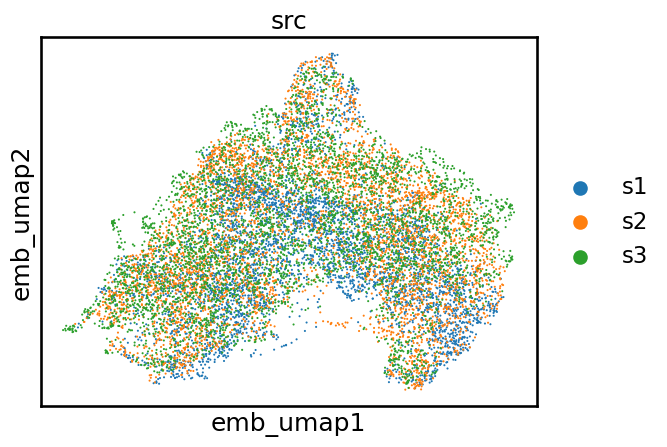

In [9]:
ad_mosaic = get_umap(ad_mosaic, ['emb'])
wrap_warn_plot(ad_mosaic, 'emb_umap', ['src'])

In [10]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batch'],
    label_keys = [],
    use_rep='emb', use_neighbors=False,
)
lisi_res['batch_iLISI'][0]

0.5614882591553816

### batch corr

In [11]:
from batchCorr import HARMONY

ad_mosaic.obsm['emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['emb']), ad_mosaic.obs['src'].to_list())
split_ob([ad_train_mean_enc, input_test_mod1, input_test_mod2], ad_mosaic, ob='obsm', key='emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [12]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batch'],
    label_keys = [],
    use_rep='emb_har', use_neighbors=False,
)
lisi_res['batch_iLISI'][0]

0.7869263988101043

## vis

In [14]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/Tonsil_3slices_fuck/clue'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['emb'], index=ad_mosaic.obs_names)
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['emb_har'], index=ad_mosaic.obs_names)
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))